In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *
from cell_utilities import *
from learning_utilities import *
from distributed_utilities import download_from_s3_to_ec2

In [25]:
n_radial = 4
# radial_bins = np.logspace(0, 2, 10, base=10)
radial_bins = np.linspace(0, 100, n_radial+1)

n_angular = 8
angular_bins = np.linspace(-np.pi, np.pi, n_angular+1)

n_orientation_bins = 10
orientation_bins = np.linspace(-np.pi/2, np.pi/2, n_orientation_bins+1)

size_histogram_bins = np.r_[np.linspace(0, 3000, 10), np.inf]

n_edge_length_bins = 10
edge_length_bins = np.r_[np.linspace(0, 100, n_edge_length_bins), np.inf]

n_edge_direction_bins = 10
edge_direction_bins = np.linspace(-np.pi/2, np.pi/2, n_edge_direction_bins+1)

In [3]:
stack = 'MD589'

In [19]:
sec = 200

# Show whole image with patch bounding boxes

In [ ]:
patch_size = 224
half_size = patch_size/2
patch_spacing = 56

im = patch_boxes_overlay_on(bg='original', downscale_factor=1, locs=locations, patch_size=patch_size, stack=stack, sec=sec)
display_image(im)

# Intrdocude Region Labels

In [36]:
sec = 208

In [42]:
cell_sizes = load_cell_data('cellSizes', stack=stack, sec=sec, ext='bp')

In [56]:
cell_orientations = load_cell_data('orientation', stack, sec)
cell_orientations = np.array(map(normalize_angle, cell_orientations))

cell_centroids = load_cell_data('centroid', stack, sec)
cell_numbers = cell_centroids.shape[0]

In [63]:
# For visualization

cell_contours = load_cell_data('contours', stack=stack, sec=sec)
n_cells = len(cell_contours)

cell_mask_centers = load_cell_data('mask_center', stack=stack, sec=sec)
cell_contours_global = {i: cell_centroids[i].astype(np.int) - cell_mask_centers[i] + cell_contours[i]
                        for i in range(cell_numbers)}

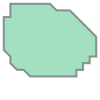

In [71]:
from shapely.geometry import Polygon
Polygon(cell_contours_global[10])

# Features for large cell only

In [40]:
large_cell_indices = load_cell_data('largeCellIndices', stack=stack, sec=sec, ext='bp')
large_cell_indices_list = large_cell_indices.tolist()

In [45]:
len(large_cell_indices)

30368

In [37]:
neighbors = load_cell_data(what='neighborCellIndices', stack=stack, sec=sec, ext='hdf')
neighbor_vectors = load_cell_data(what='neighborVectors', stack=stack, sec=sec, ext='hdf')
radial_indices = load_cell_data(what='neighborRadialHistBins', stack=stack, sec=sec, ext='hdf')
angular_indices = load_cell_data(what='neighborAngularHistBins', stack=stack, sec=sec, ext='hdf')

In [48]:
neighbors[100] # 100th largeCell's neighbors (incl. large and small)

array([339,  70, 105,  81, 451,  40, 419, 538, 365, 261, 559,  89, 590,
       395, 640, 204, 118])

In [49]:
neighbor_vectors[100]

array([[  10.74427579,  -27.64522768],
       [  10.71506013,   31.66436343],
       [ -26.6093778 ,   20.73978586],
       [  31.50488988,   28.06319855],
       [   9.12721893,  -50.20710059],
       [ -40.17373269,   38.08711035],
       [  36.24832081,  -45.81780745],
       [ -14.06891102,  -68.58837149],
       [ -62.98816568,  -31.92038731],
       [ -79.64670227,   -9.50353586],
       [ -34.56350815,  -72.81827024],
       [  77.54448037,   26.88436121],
       [  23.95029586,  -78.97633136],
       [  79.22427742,  -35.4646003 ],
       [  52.61422794,  -82.4888109 ],
       [ 100.12461627,    1.06560039],
       [ 104.75588194,   19.45407157]])

In [54]:
print radial_indices[100]
print radial_bins

[1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 4 4]
[   0.   25.   50.   75.  100.]


In [55]:
print angular_indices[100]
print angular_bins

[1 4 6 4 1 6 2 0 7 7 0 3 1 2 1 3 3]
[-3.14159265 -2.35619449 -1.57079633 -0.78539816  0.          0.78539816
  1.57079633  2.35619449  3.14159265]


# Region Label

In [ ]:
contour_df, _ = DataManager.load_annotation_v3(stack=stack)
from annotation_utilities import convert_annotation_v3_original_to_aligned_cropped
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df, stack)

contour_df.iloc[1]

In [72]:
contours = {cnt['name']: cnt['vertices'] for cnt_id, cnt in contour_df[contour_df['section'] == sec].iterrows()}

In [180]:
name_u = '12N'
cnt = contours[name_u]

In [181]:
large_cell_centroids = cell_centroids[large_cell_indices]

In [182]:
from matplotlib.path import Path
large_cell_is_inside = Path(cnt.astype(np.int)).contains_points(large_cell_centroids)
large_cell_indices_inside = large_cell_indices[large_cell_is_inside]

In [183]:
small_cell_indices = np.array(list(set(range(cell_numbers)) - set(large_cell_indices.tolist())))
small_cell_centroids = cell_centroids[small_cell_indices]
small_cell_is_inside = Path(cnt.astype(np.int)).contains_points(small_cell_centroids)
small_cell_indices_inside = small_cell_indices[small_cell_is_inside]

In [258]:
cell_to_watch_global_index = 67315
cell_to_watch_index_among_large = large_cell_indices_list.index(cell_to_watch_global_index)

print np.bincount(angular_indices[cell_to_watch_index_among_large], minlength=len(angular_bins)-1)
print np.bincount(radial_indices[cell_to_watch_index_among_large], minlength=len(radial_bins))

[2 2 3 2 0 3 4 1]
[0 3 5 9 0]


In [246]:
image = load_cell_data('image', stack=stack, sec=sec)

In [263]:
#############
# Visualize #
#############

viz = image.copy()

# Draw large cell boundaries
for i in large_cell_indices_inside:
    cv2.polylines(viz, [cell_contours_global[i].astype(np.int)], isClosed=True, color=(255,0,0), thickness=1)

# Draw small cell boundaries
for i in small_cell_indices_inside:
    cv2.polylines(viz, [cell_contours_global[i].astype(np.int)], isClosed=True, color=(0,255,0), thickness=1)

# Draw structure boundary
cv2.polylines(viz, [cnt.astype(np.int)], isClosed=True, color=(0,0,255), thickness=1)

# Visualize radial-angular histogram of selected cells
random_large_cell_indices = large_cell_indices_inside
# random_large_cell_indices = large_cell_indices_inside
#     random_large_cell_indices = np.random.choice(large_cell_indices_inside, 2, replace=False)

for source in random_large_cell_indices:

    cv2.circle(viz, tuple(cell_centroids[source].astype(np.int)), 6, color=(255,0,0), thickness=-1)

    neighbor_distances = np.sqrt(np.sum(neighbor_vectors[large_cell_indices_list.index(source)]**2, axis=1))

    c = 0
    for i in np.array(neighbors[large_cell_indices_list.index(source)])[np.argsort(neighbor_distances)]:
#         for i in neighbors[source]:

#         # Draw link to large cells
#         if i in large_cell_indices_inside:

#             cv2.circle(viz, tuple(cell_centroids[i].astype(np.int)), 3, color=(255,0,0), thickness=-1)

#             cv2.line(viz, tuple(cell_centroids[source].astype(np.int)), 
#                  tuple(cell_centroids[i].astype(np.int)), 
#                  color=(255,0,0), thickness=3)

#             c += 1
#             if c == 3:
#                 break

#         # Draw link to small cells
#         if i in small_cell_indices_inside:

#             cv2.circle(viz, tuple(cell_centroids[i].astype(np.int)), 3, color=(0,255,0), thickness=-1)            

#             cv2.line(viz, tuple(cell_centroids[source].astype(np.int)), 
#                      tuple(cell_centroids[i].astype(np.int)), 
#                      color=(0,0,0), thickness=1)    
    
            
        if source == cell_to_watch_global_index:
            # Draw radial bins
            for rb in radial_bins:
                cv2.circle(viz, tuple(cell_centroids[source].astype(np.int)), 
                          int(rb), color=(0,0,255), thickness=1)

            # Draw angular bins
            for abi, ab in enumerate(angular_bins[:-1]):
                
                near_end = cell_centroids[source].astype(np.int)
                far_end = (cell_centroids[source] + (np.cos(ab - cell_orientations[source])*100, 
                                                     np.sin(ab - cell_orientations[source])*100)).astype(np.int)
                
                cv2.line(viz, tuple(near_end), tuple(far_end),
                 color=(0,0,255), thickness=1)
                cv2.putText(viz, str(abi), tuple((near_end + far_end)/2), cv2.FONT_HERSHEY_DUPLEX, 1, ((0,0,0)), 2)

# Find crop box

margin = 50
roi_xmin, roi_ymin = cnt.astype(np.int).min(axis=0) - margin
roi_xmax, roi_ymax = cnt.astype(np.int).max(axis=0) + margin
print roi_xmin, roi_xmax, roi_ymin, roi_ymax

cropped_viz = viz[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1]

10774 11921 8334 9178


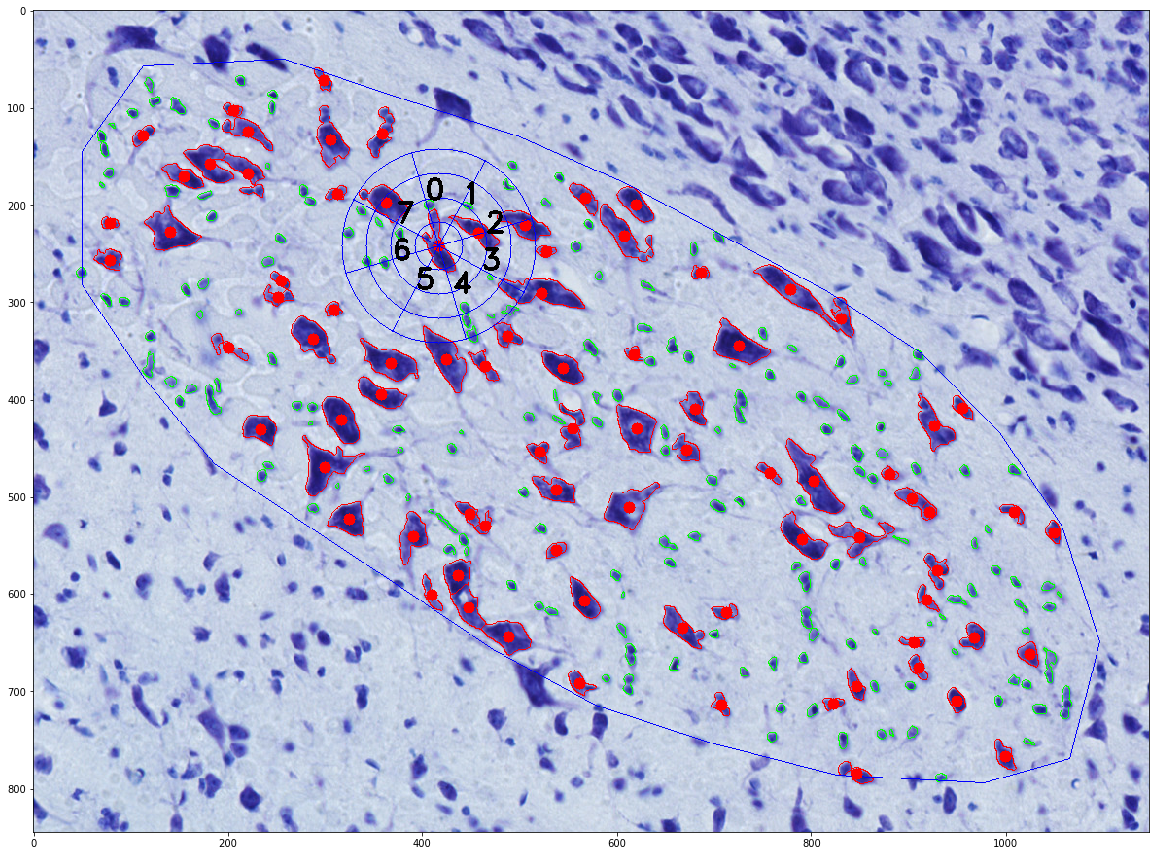

In [264]:
plt.figure(figsize=(20,20));
plt.imshow(cropped_viz);

# Load region features

In [99]:
region_features = load_cell_classifier_data(what='region_features', ext='hdf', stack=stack, sec=sec)
region_contours = load_cell_classifier_data(what='region_contours', ext='bp', stack=stack, sec=sec)

{'allSizeHist': array([31,  4,  0,  0,  0,  0,  0,  0,  0,  0]),
 'huMomentsHist': array([[1, 3, 2, 1, 2, 2, 0, 1, 0, 1],
        [3, 0, 0, 2, 0, 0, 1, 0, 0, 7],
        [2, 3, 1, 0, 2, 1, 0, 1, 0, 3],
        [1, 3, 2, 1, 1, 1, 2, 0, 1, 1],
        [4, 3, 1, 1, 1, 1, 0, 1, 0, 1],
        [5, 2, 1, 1, 0, 2, 1, 0, 0, 1],
        [5, 2, 1, 1, 2, 0, 0, 1, 0, 1]]),
 'largeLargeLinkDirHist': array([ 6, 10,  5,  3,  1,  4,  4,  6,  3,  3]),
 'largeLargeLinkJacHist': array([1, 0, 6, 8, 7, 5, 5, 2, 8, 3]),
 'largeLargeLinkLenHist': array([ 0,  1,  5,  5,  3,  6,  4, 10,  7,  4]),
 'largeLargeLinkOrientationDiffHist': array([3, 4, 4, 9, 5, 6, 6, 3, 3, 2]),
 'largeLargeLinkSizeDiffHist': array([8, 5, 7, 3, 6, 3, 0, 4, 4, 5]),
 'largeOrientationHist': array([1, 2, 4, 3, 1, 1, 1, 0, 0, 0]),
 'largeSizeHist': array([9, 4, 0, 0, 0, 0, 0, 0, 0, 0]),
 'largeSizeWeightedHist': array([3607, 1620,    0,    0,    0,    0,    0,    0,    0,    0]),
 'largeSmallLinkDirHist': array([10, 12, 14, 12, 14, 21, 1

In [130]:
region_contours[283]

array([[  56, 6048],
       [  56, 6272],
       [ 280, 6272],
       [ 280, 6048]])

In [131]:
region_features[283]

{'allSizeHist': array([31,  4,  0,  0,  0,  0,  0,  0,  0,  0]),
 'huMomentsHist': array([[1, 3, 2, 1, 2, 2, 0, 1, 0, 1],
        [3, 0, 0, 2, 0, 0, 1, 0, 0, 7],
        [2, 3, 1, 0, 2, 1, 0, 1, 0, 3],
        [1, 3, 2, 1, 1, 1, 2, 0, 1, 1],
        [4, 3, 1, 1, 1, 1, 0, 1, 0, 1],
        [5, 2, 1, 1, 0, 2, 1, 0, 0, 1],
        [5, 2, 1, 1, 2, 0, 0, 1, 0, 1]]),
 'largeLargeLinkDirHist': array([ 6, 10,  5,  3,  1,  4,  4,  6,  3,  3]),
 'largeLargeLinkJacHist': array([1, 0, 6, 8, 7, 5, 5, 2, 8, 3]),
 'largeLargeLinkLenHist': array([ 0,  1,  5,  5,  3,  6,  4, 10,  7,  4]),
 'largeLargeLinkOrientationDiffHist': array([3, 4, 4, 9, 5, 6, 6, 3, 3, 2]),
 'largeLargeLinkSizeDiffHist': array([8, 5, 7, 3, 6, 3, 0, 4, 4, 5]),
 'largeOrientationHist': array([1, 2, 4, 3, 1, 1, 1, 0, 0, 0]),
 'largeSizeHist': array([9, 4, 0, 0, 0, 0, 0, 0, 0, 0]),
 'largeSizeWeightedHist': array([3607, 1620,    0,    0,    0,    0,    0,    0,    0,    0]),
 'largeSmallLinkDirHist': array([10, 12, 14, 12, 14, 21, 1

[(6048, 6272, 56, 280), (224, 448, 168, 392), (7168, 7392, 280, 504), (6160, 6384, 3976, 4200)]


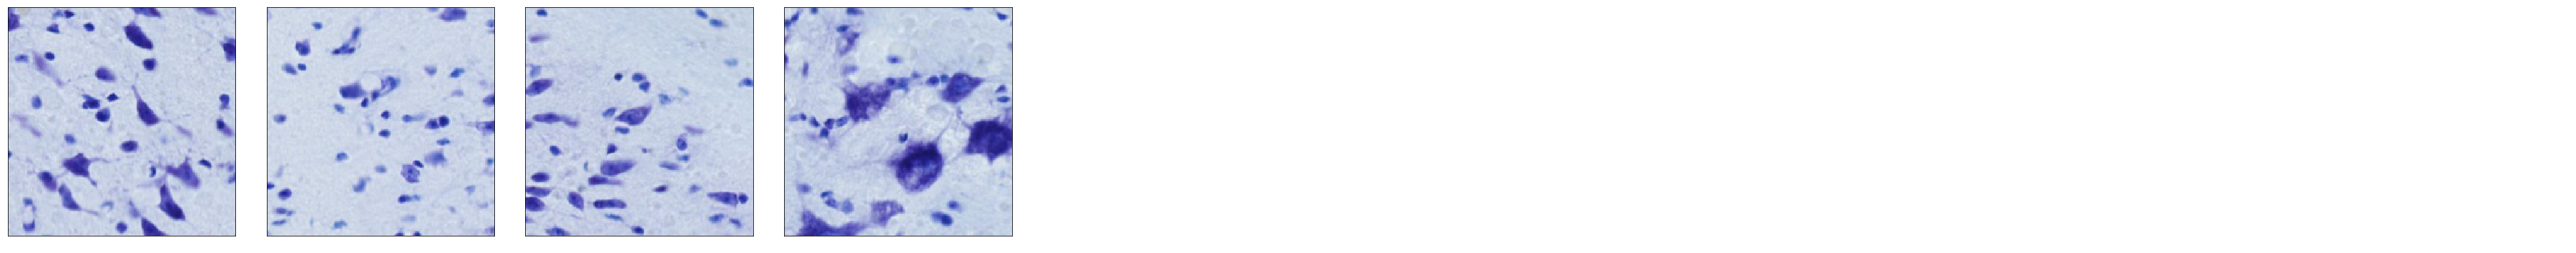

In [132]:
center_locations = [region_contours[283].mean(axis=0).astype(np.int), 
             region_contours[527].mean(axis=0).astype(np.int), 
             region_contours[999].mean(axis=0).astype(np.int), 
             region_contours[12421].mean(axis=0).astype(np.int)]

patch_list = extract_patches_given_locations(stack=stack, sec=sec, locs=center_locations)
display_images_in_grids(patch_list, nc=10)

In [282]:
regions_to_plot = [283, 527, 999, 12421, 283, 527, 999, 12421, 283, 527, 999, 12421]

In [283]:
histograms = [region_features[gi]['allSizeHist'] for gi in regions_to_plot]

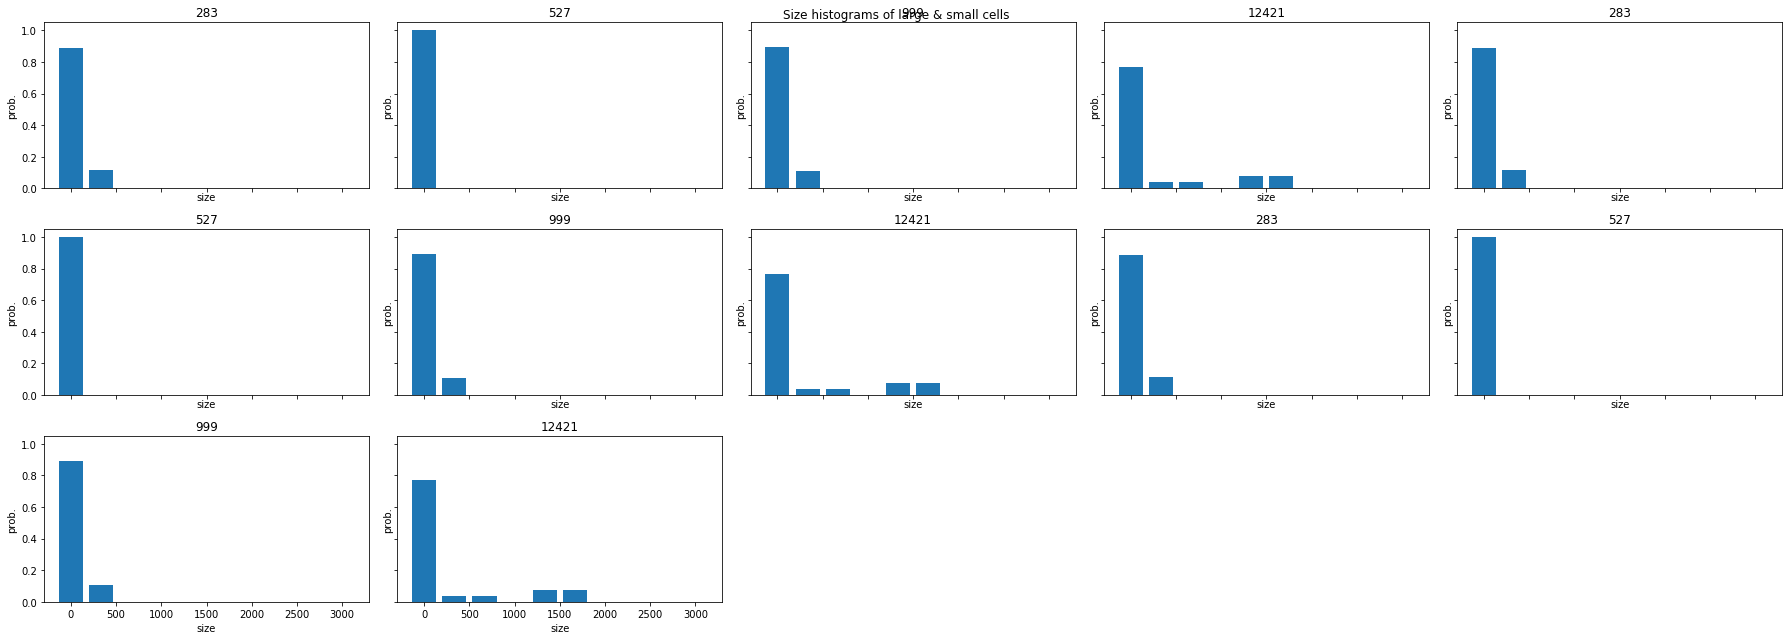

In [290]:
plot_histograms(histograms, bins=size_histogram_bins[:-1], titles=map(str, regions_to_plot), 
                ncols=5,
               xlabel='size', ylabel='prob.', suptitle='Size histograms of large & small cells', cellsize=(5,3));

In [291]:
# for gi in [283, 527, 999, 12421]:
#     plt.figure(figsize=(3,2));
#     plt.bar(range(len(size_histogram_bins))[:-1], region_features[gi]['allSizeHist']);
#     plt.title(str(gi));
#     plt.show();

# Label Regions

In [294]:
# contours_df = contour_df

In [295]:
# labeled_contours = contours_df[(contours_df['orientation'] == 'sagittal') & (contours_df['downsample'] == 1)]
# labeled_contours = labeled_contours.drop_duplicates(subset=['section', 'name', 'side', 'filename', 'downsample', 'creator'])
# labeled_contours = convert_annotation_v3_original_to_aligned_cropped(labeled_contours, stack=stack)

In [415]:
margins_to_sample = [500] # (100 um, 250 um)

In [416]:
region_labels = label_regions(stack=stack, section=sec, region_contours=region_contours,
                              surround_margins=margins_to_sample,
                              labeled_contours=contour_df[contour_df['section'] == sec])

Analyzing section 208..


In [417]:
grid_to_location = grid_parameters_to_sample_locations(get_default_gridspec(stack=stack, patch_size=patch_size, stride=patch_spacing))

In [319]:
im = patch_boxes_overlay_on(bg='original', downscale_factor=8, locs=grid_to_location[[29202, 18422]], patch_size=patch_size,
                      stack=stack, sec=sec)

In [334]:
display_image(im)

/shared/MouseBrainAtlas/cells/tmp.jpg

In [446]:
region_centroids = region_contours.mean(axis=1).astype(np.int)

In [447]:
location_to_grid = {tuple(loc): i for i, loc in enumerate(grid_to_location)}

In [451]:
grid_indices_per_label = {label: [location_to_grid[tuple(c)] for c in region_centroids[region_indices]] 
                          for label, region_indices in region_labels.iteritems()}

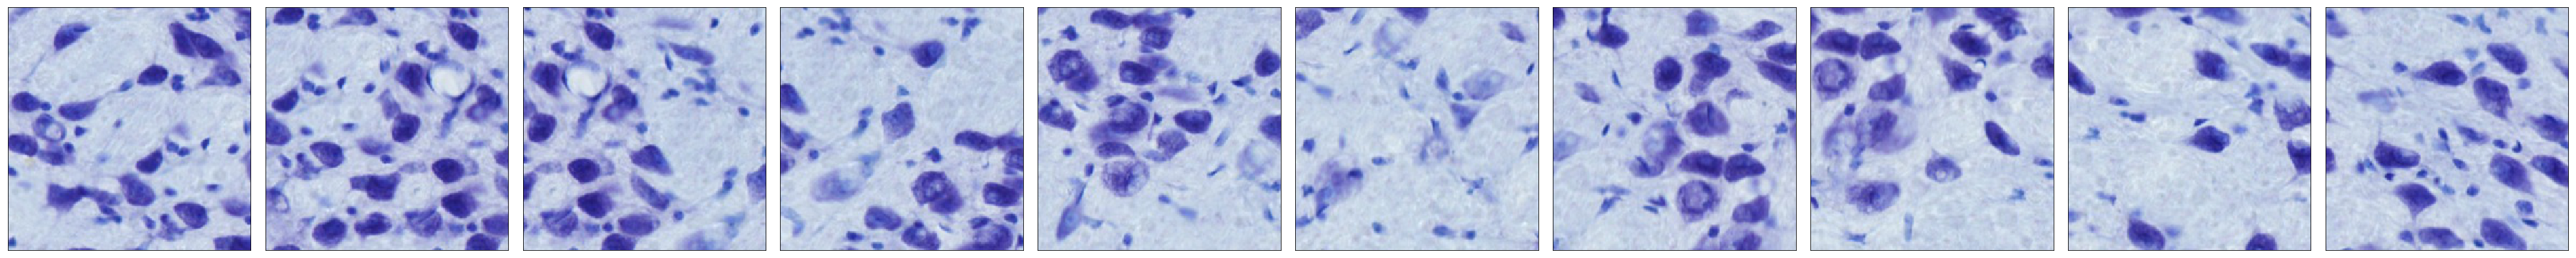

In [463]:
patches = extract_patches_given_locations(stack=stack, sec=sec, indices=grid_indices_per_label['Tz'], version='compressed')
display_images_in_grids(patches[::10], nc=10)

In [464]:
patches = extract_patches_given_locations(stack=stack, sec=sec, indices=grid_indices_per_label['Tz_surround_500_noclass'], version='compressed')
display_images_in_grids(patches[::10], nc=10)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [462]:
im = patch_boxes_overlay_on(bg='original', downscale_factor=8, 
                            locs=region_centroids[region_labels['Tz_surround_500_noclass'][::10]], 
                            patch_size=patch_size,
                      stack=stack, sec=sec)
display_image(im)

/shared/MouseBrainAtlas/cells/tmp.jpg

In [ ]:
training_addresses_by_section = []

    first_sec, last_sec = metadata_cache['section_limits'][stack]
    
    sys.stderr.write('Load annotation. Time: %.2s seconds.\n' % (time.time() - t1))
    
    def label_region_worker(sec):
    
        training_addresses = {}

        if is_invalid(stack=stack, sec=sec):
            return

        region_contours = bp.unpack_ndarray_file(get_cell_classifier_data_filepath(what='region_contours', stack=stack, sec=sec, ext='bp'))
        region_labels = label_regions(stack=stack, section=sec, region_contours=region_contours,
                                      surround_margins=margins_to_sample,
                                      labeled_contours=labeled_contours[labeled_contours['section'] == sec])

        for label, region_indices in region_labels.iteritems():
            if label == 'bg' or len(region_indices) == 0:
                continue
            sampled_region_indices = np.random.choice(region_indices, min(10, len(region_indices)), replace=False)
            training_addresses[label] = [(stack, sec, ridx) for ridx in sampled_region_indices]

        return training_addresses
    
    t1 = time.time()
    
    pool = Pool(8)
    training_addresses_by_section_curr_stack = pool.map(lambda sec: label_region_worker(sec), range(first_sec, last_sec+1))
    pool.close()
    pool.join()
    
    training_addresses_by_section += training_addresses_by_section_curr_stack
    
    sys.stderr.write('Sample training addresses. Time: %.2s seconds.\n' % (time.time() - t1)) # 13 seconds.
    
training_addresses = defaultdict(list)
for train_addrs_by_label in training_addresses_by_section:
    if train_addrs_by_label is None: continue
    for label, addrs in train_addrs_by_label.iteritems():
        training_addresses[label] += addrs